In [60]:
import pickle
import xarray as xr
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.fftpack import fft, ifft
import numpy
import matplotlib.pyplot as plt

Here we evaluate the robustness of each of the 6 atmospheric inversion models to the Global Carbon Project observations.<br><br>
Note that GCP land flux = land (from DGVMs) + BIM (budget imbalance) which represents the residual flux. This keeps the analysis consistent with comparing models to observations (GCP).

In [2]:
# Models
CAMS = pd.read_csv("./../Output/output_raw/output_CAMS.csv").set_index("Year")
CTRACKER = pd.read_csv("./../Output/output_raw/output_CTRACKER.csv").set_index("Year")
Rayner = pd.read_csv("./../Output/output_raw/output_Rayner.csv").set_index("Year")
JAMSTEC = pd.read_csv("./../Output/output_raw/output_JAMSTEC.csv").set_index("Year")
JENA_s76 = pd.read_csv("./../Output/output_raw/output_JENA_s76.csv").set_index("Year")
JENA_s85 = pd.read_csv("./../Output/output_raw/output_JENA_s85.csv").set_index("Year")

In [3]:
#GCP
fGCB = './../../Prelim_Data_Analysis/gcb_data/budget.csv'
df = pd.read_csv(fGCB,
                 index_col=0,
                 usecols=[0,4,5,6])
df.head()

,ocean sink,land sink,budget imbalance
Year,,,
1959,0.852376,0.516073,0.860316
1960,0.819017,1.394030,0.522722
1961,0.714842,0.605098,1.213762
1962,0.756709,1.348349,0.959605
1963,0.904997,0.877794,1.355333


In [4]:
fCO2 = './../co2_temp_data/co2_global.csv'
CO2 = pd.read_csv(fCO2, index_col=0)[2:]
CO2.head()

,CO2
Year,
1959,315.486
1960,316.163
1961,316.856
1962,317.558
1963,318.268


In [5]:
df['CO2'] = CO2
df['land sink'] = -df['land sink']
df['ocean sink'] = -df['ocean sink']
df['budget imbalance'] = -df["budget imbalance"]+df['land sink']

df.head()

,ocean sink,land sink,budget imbalance,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [6]:
df.rename(columns={"ocean sink": "ocean", "land sink": "land (model)", "budget imbalance": "land"},
         inplace=True)
df.head()

,ocean,land (model),land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


# Plots

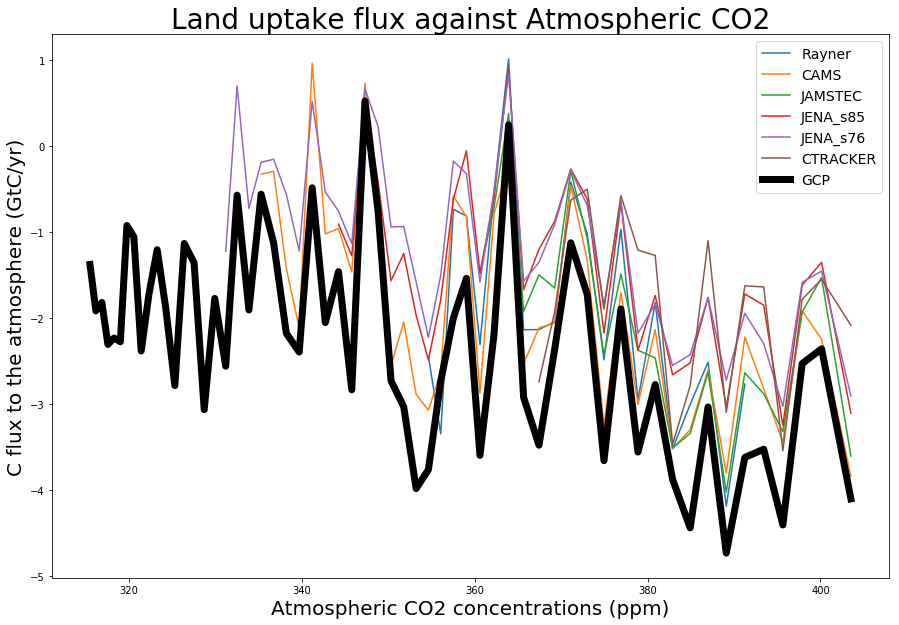

In [7]:
plt.figure(figsize=(15,10))

plt.plot(df.loc[1992:2012].CO2, Rayner.Earth_Land)
plt.plot(df.loc[1979:2017].CO2, CAMS.Earth_Land)
plt.plot(df.loc[1996:2017].CO2, JAMSTEC.Earth_Land)
plt.plot(df.loc[1985:2017].CO2, JENA_s85.Earth_Land)
plt.plot(df.loc[1976:2017].CO2, JENA_s76.Earth_Land)
plt.plot(df.loc[2000:2017].CO2, CTRACKER.Earth_Land)
plt.plot(df.CO2, df.land, linewidth=7, color='k')

plt.title("Land uptake flux against Atmospheric CO2", fontsize=28)
plt.xlabel("Atmospheric CO2 concentrations (ppm)", fontsize=20)
plt.ylabel("C flux to the atmosphere (GtC/yr)", fontsize=20)
plt.legend(["Rayner", "CAMS", "JAMSTEC", "JENA_s85", "JENA_s76", "CTRACKER", "GCP"], fontsize=14)

In [8]:
pickle.dump([df.CO2, df.land], open("./GCP_land.pik", "wb"))

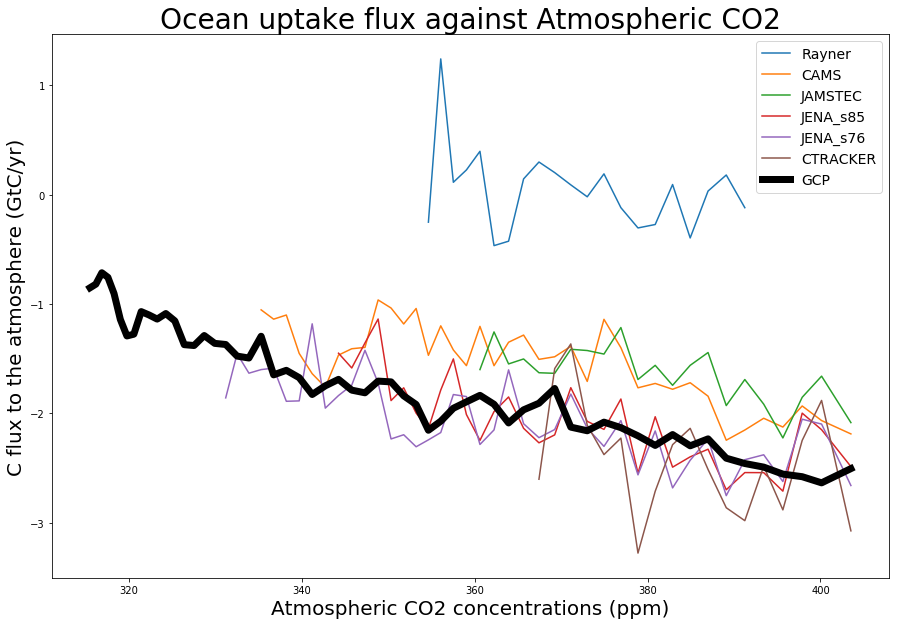

In [9]:
plt.figure(figsize=(15,10))

plt.plot(df.loc[1992:2012].CO2, Rayner.Earth_Ocean)
plt.plot(df.loc[1979:2017].CO2, CAMS.Earth_Ocean)
plt.plot(df.loc[1996:2017].CO2, JAMSTEC.Earth_Ocean)
plt.plot(df.loc[1985:2017].CO2, JENA_s85.Earth_Ocean)
plt.plot(df.loc[1976:2017].CO2, JENA_s76.Earth_Ocean)
plt.plot(df.loc[2000:2017].CO2, CTRACKER.Earth_Ocean)
plt.plot(df.CO2, df.ocean, linewidth=7, color='k')

plt.title("Ocean uptake flux against Atmospheric CO2", fontsize=28)
plt.xlabel("Atmospheric CO2 concentrations (ppm)", fontsize=20)
plt.ylabel("C flux to the atmosphere (GtC/yr)", fontsize=20)
plt.legend(["Rayner", "CAMS", "JAMSTEC", "JENA_s85", "JENA_s76", "CTRACKER", "GCP"], fontsize=14)

In [10]:
pickle.dump([df.CO2, df.ocean], open("./GCP_ocean.pik", "wb"))

# Global Uptake timeseries

In [11]:
GCB = df; GCB.head()

,ocean,land (model),land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [12]:
def model_GCP_timeseries(model, GCB_sink):
    
    if "land" in GCB_sink:
        model_sink = "Earth_Land"
    elif "ocean" in GCB_sink:
        model_sink = "Earth_Ocean"
    
    plt.figure(figsize=(14,9))
    plt.subplot(211).plot(model.index, GCB.loc[model.index][GCB_sink])
    plt.subplot(211).plot(model[model_sink])
    plt.legend(["GCP", "model"])
    plt.subplot(212).scatter(GCB.loc[model.index][GCB_sink], model[model_sink])
    
    return stats.linregress(GCB.loc[model.index][GCB_sink], model[model_sink])

/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


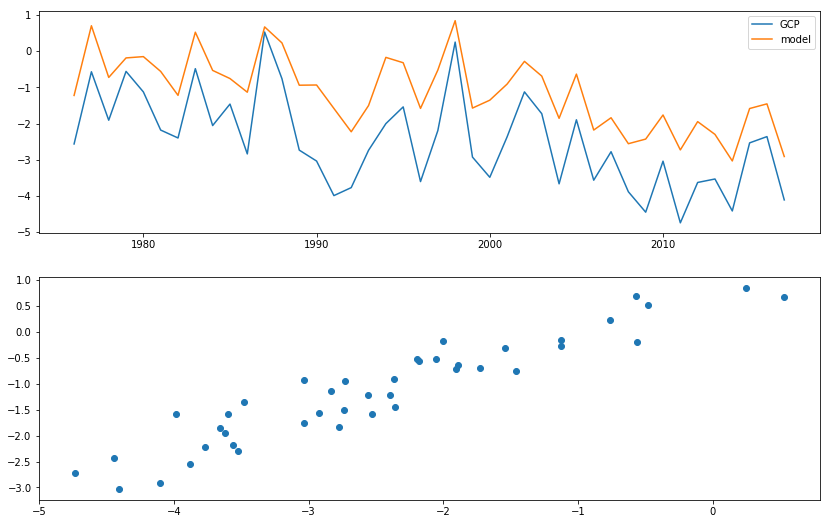

In [13]:
model_GCP_timeseries(JENA_s76 , "land");

LinregressResult(slope=0.7654909291344756, intercept=0.7449810716426817, rvalue=0.7632484567409027, pvalue=4.173736814427203e-09, stderr=0.10245833257091637)

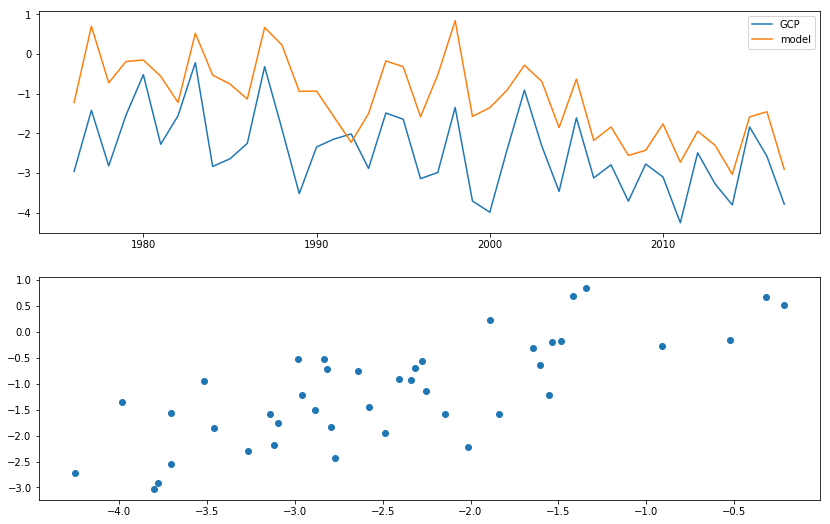

In [14]:
model_GCP_timeseries(JENA_s76 , "land (model)")

LinregressResult(slope=0.6108813106727659, intercept=-0.28207379937717403, rvalue=0.6188491638241481, pvalue=0.002136703683655757, stderr=0.17338385839363546)

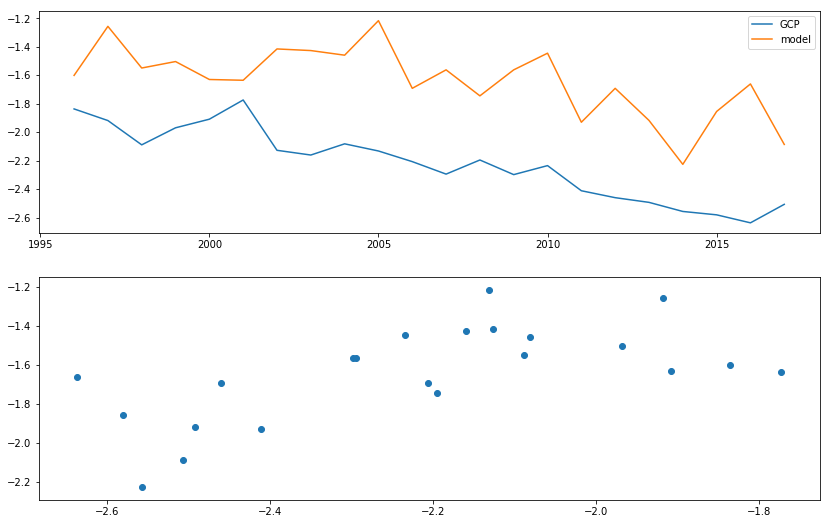

In [15]:
model_GCP_timeseries(JAMSTEC, "ocean")

# Rolling gradient

In [16]:
def get_fname(model, sink):
    return f"./../Output/output_linreg/{model}/roll_df_{sink}.pik"

In [17]:
get_fname("GCP", "land")

'./../Output/output_linreg/GCP/roll_df_land.pik'

In [18]:
CAMS_roll_land = pickle.load(open(get_fname("CAMS", "land"), "rb"))

In [23]:
GCP_roll_land = pickle.load(open(get_fname("GCP", "land"), "rb"))["10-year trend slope"]

In [24]:
GCP_roll_ocean = pickle.load(open(get_fname("GCP", "ocean"), "rb"))["10-year trend slope"]

In [25]:
GCP_roll = pd.DataFrame({"land": GCP_roll_land.values, "ocean": GCP_roll_ocean.values}, index=GCP_roll_land.index)
GCP_roll.head()

,land,ocean
Year,,
1959,0.047010,-0.058203
1960,0.057761,-0.048810
1961,-0.012407,-0.039594
1962,0.032807,-0.034183
1963,0.027451,-0.025706


In [26]:
def model_GCP_rolling_trend(model_df, GCP_df):
    
    plt.figure(figsize=(14,9))
    plt.subplot(211).plot(model_df.index, GCP_df.loc[model_df.index])
    plt.subplot(211).plot(model_df)
    plt.legend(["GCP", "model"])
    plt.subplot(212).scatter(GCP_df.loc[model_df.index], model_df)
    
    return stats.linregress(GCP_df.loc[model_df.index].values.squeeze(), model_df.values.squeeze())

LinregressResult(slope=0.8940030852482888, intercept=-0.005140358586918345, rvalue=0.9383558386815568, pvalue=5.646160165483558e-14, stderr=0.0633800098560126)

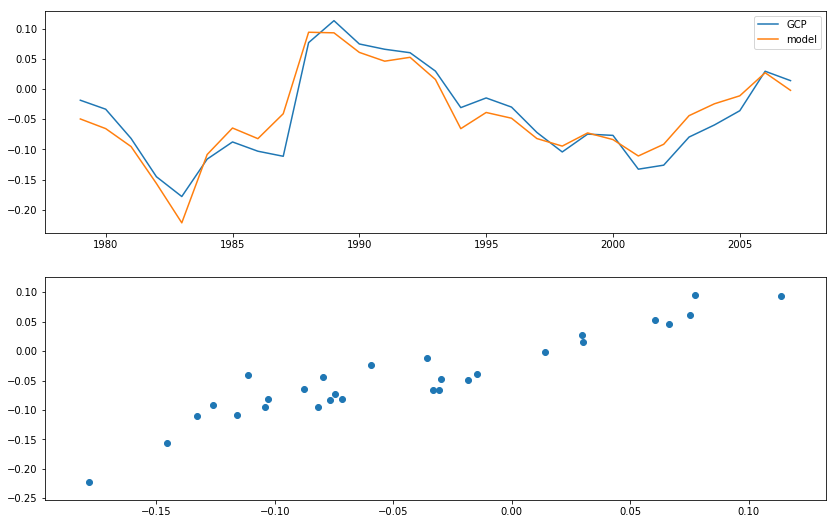

In [27]:
model_GCP_rolling_trend(CAMS_roll_land, GCP_roll_land)

In [28]:
def roll_open_model_and_evaluate(model, sink):
    model_to_evaluate = pickle.load(open(get_fname(model, sink), "rb"))
    return model_GCP_rolling_trend(model_to_evaluate, GCP_roll[sink])

LinregressResult(slope=0.8041896125152064, intercept=0.0026565136099056495, rvalue=0.9130587834797828, pvalue=1.2344824468794142e-09, stderr=0.07838393951361305)

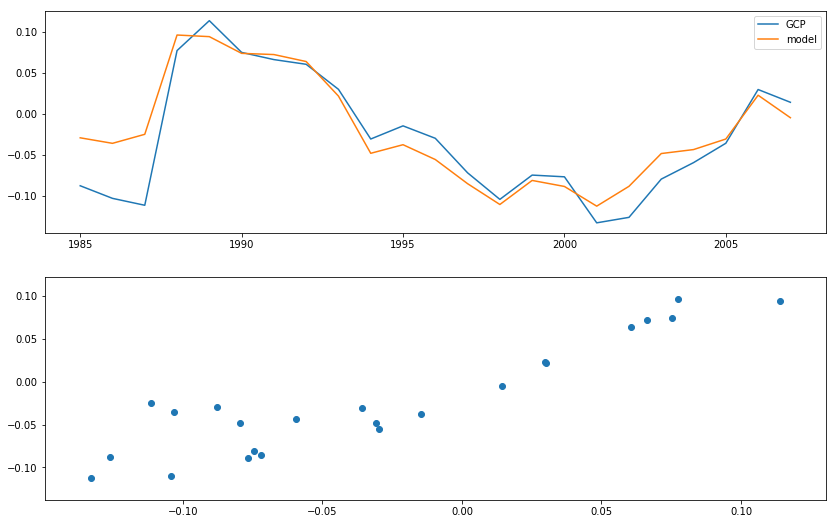

In [29]:
roll_open_model_and_evaluate("JENA_s85", "land")

LinregressResult(slope=-6.02825232538672, intercept=-0.1349378225216691, rvalue=-0.49320579860014, pvalue=0.2142618234368792, stderr=4.340735025231271)

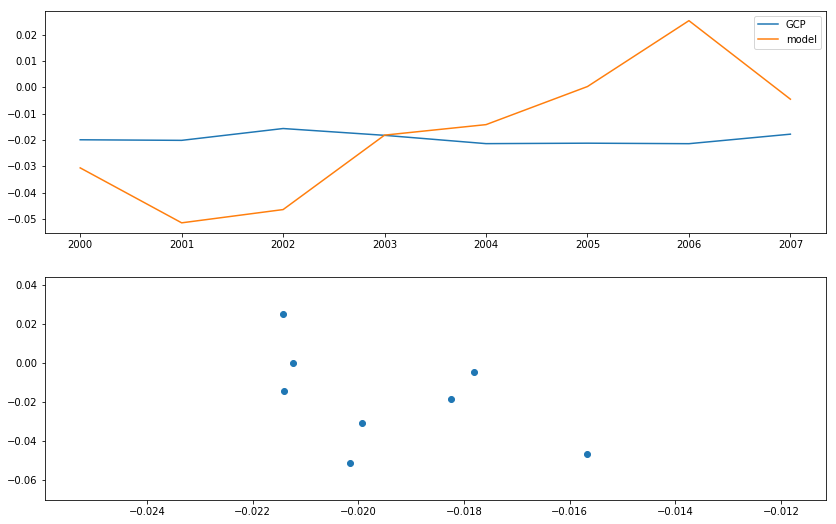

In [31]:
roll_open_model_and_evaluate("CTRACKER", "ocean")

COMMENTS: All land models correlate well with GCP land, but ocean is poorly correlated.

# Frequency spectrum & other statistical analyses

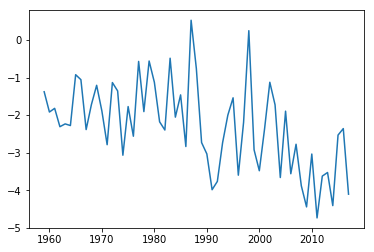

In [41]:
plt.plot(GCB["land"])

/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


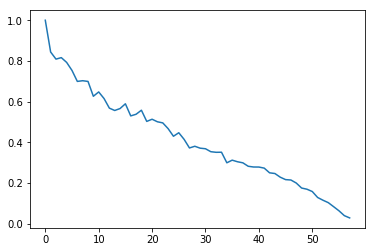

In [62]:
auto_cor = signal.correlate(GCB["land"], GCB["land"])
halfway_index = int((len(auto_cor)+1)/2)-1
plt.plot(auto_cor[halfway_index:-1]/auto_cor[halfway_index])

Other things to do:
- Frequency correlation
- Cross-correlation
- Refer to stats course (sem 1) for more things to do

In [122]:
def power_spec(N, T, y):
    """
    N = no. of sample points.
    T = sample spacing.
    """
    x = np.linspace(0, N*T, N)
    xf = np.linspace(0, 1.0/(2.*T), N//2)
    yf = fft(y)
    y_plot = 2.0/N * np.abs(yf[0:N//2])
    
    df = (pd
          .DataFrame({"Frequency (1/year)": xf[1:],
                      "Time Period (year)": 1/(xf[1:]),
                      "Spectral Variance (GtC)^2.yr": y_plot[1:]
                     }
                    )
          .set_index("Frequency (1/year)")
         )
    
    plt.semilogy(df["Spectral Variance (GtC)^2.yr"])
    plt.xlabel("Frequency (1/year)")
    plt.ylabel("Spectral Variance (GtC)^2.yr")
    
    return df


,Time Period (year),Spectral Variance (GtC)^2.yr
Frequency (1/year),,
0.017857,56.000000,0.065359
0.035714,28.000000,0.067641
0.053571,18.666667,0.071814
0.071429,14.000000,0.078591
0.089286,11.200000,0.089411
0.107143,9.333333,0.107429
0.125000,8.000000,0.140834
0.142857,7.000000,0.219019
0.160714,6.222222,0.584584


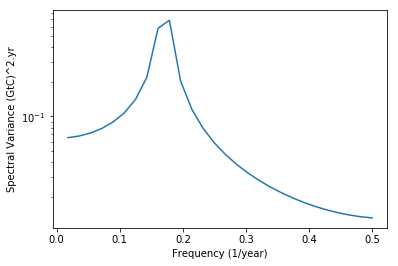

In [123]:
power_spec(59,1,np.sin(x))

,Time Period (year),Spectral Variance (GtC)^2.yr
Frequency (1/year),,
0.017857,56.000000,0.798037
0.035714,28.000000,0.300459
0.053571,18.666667,0.583986
0.071429,14.000000,0.171488
0.089286,11.200000,0.066873
0.107143,9.333333,0.307266
0.125000,8.000000,0.286570
0.142857,7.000000,0.247804
0.160714,6.222222,0.074460


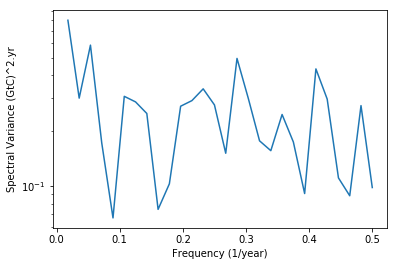

In [124]:
power_spec(59,1,GCB["land"])

In [135]:
from pandas.plotting import lag_plot, autocorrelation_plot
from pandas import concat

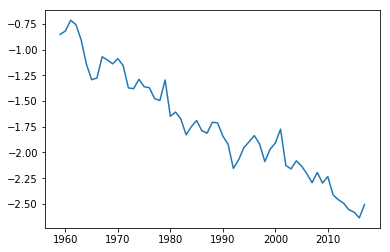

In [143]:
plt.plot(GCB["ocean"])

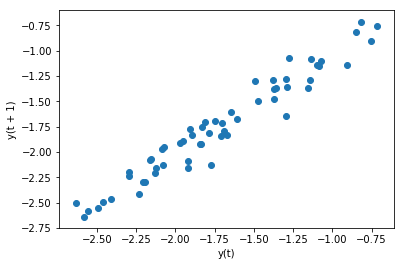

In [139]:
lag_plot(GCB["ocean"])

In [138]:
dataframe = concat([GCB["ocean"].shift(1), GCB["ocean"]], axis=1)
dataframe.columns = ['t-1', 't+1']
dataframe.corr()

,t-1,t+1
t-1,1.000000,0.971188
t+1,0.971188,1.000000


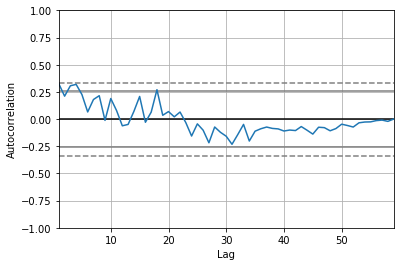

In [157]:
autocorrelation_plot(GCB["land"])

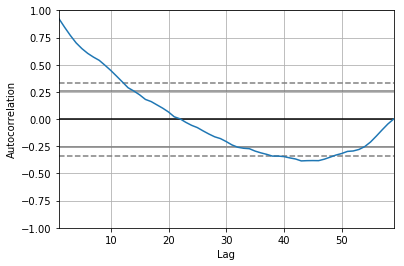

In [158]:
autocorrelation_plot(GCB["ocean"])

# Model eval of long-term trend slopes